# Classify chest x-rays as w/ or w/o abnormalities

In [ ]:
#@title Version notes { run: "auto" }
version_notes = "EfficientNetB3, include probabilities (for later double thresholding)" #@param {type:"string"}

In [ ]:
#@title Parameters { run: "auto" }
IMAGE_SIZE = 640 #@param {type:"slider", min:512, max:1024, step:64}
IMAGE_SIZE = (IMAGE_SIZE, IMAGE_SIZE)
BATCH_SIZE = 24 #@param {type:"slider", min:4, max:64, step:4}
THRESHOLD = 0.8 #@param {type:"slider", min:0, max:1, step:0.05}
TRAIN = True #@param {type: "boolean"}

In [ ]:
EXPERIMENT_NAME = f"vbdbinary_effnetb3_image{IMAGE_SIZE[0]}_batch{BATCH_SIZE}_threshold{THRESHOLD}"
print("Experiment name:", EXPERIMENT_NAME)

Experiment name: vbdbinary_effnetb3_image640_batch24_threshold0.8


## Setup

In [ ]:
try:
    from google.colab import drive
    drive.mount("/content/drive")
    %cd /content/drive/MyDrive/Colab\ Notebooks/kaggle
    from setup_colab import setup_colab_for_kaggle, OUTPUT_FOLDER, WORK_FOLDER, dump_dataset_metadata
    setup_colab_for_kaggle(check_env=False, local_working=True)
except:
    print("Not in Colab")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/kaggle
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Content of Drive Kaggle data dir (/content/drive/MyDrive/kaggle): ['/content/drive/MyDrive/kaggle/input', '/content/drive/MyDrive/kaggle/working', '/content/drive/MyDrive/kaggle/.ipynb_checkpoints', '/content/drive/MyDrive/kaggle/output']
Content of Kaggle data dir (/kaggle): ['/kaggle/working', '/kaggle/output', '/kaggle/input']
Content of Kaggle data subdir (/kaggle/input): ['/kaggle/input/cassava-model', '/kaggle/input/cassava-leaf-disease-classification', '/kaggle/input/googlebitemperedloss', '/kaggle/input/vbdyolo', '/kaggle/input/.ipynb_checkpoints', '/kaggle/input/vinbigdata', '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection', '/kaggle/input/vinbigdata-chest-xray-origi

In [ ]:
!pip install tensorflow_addons

In [ ]:
from pathlib import Path

from IPython.display import clear_output

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras.applications import EfficientNetB3 as EfficientNetBX
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tqdm.notebook import tqdm

INPUT_FOLDER_DATA = WORK_FOLDER / "vinbigdata-chest-xray-abnormalities-detection"
OUTPUT_FOLDER_CUR = OUTPUT_FOLDER / "vbdbinary"
INPUT_FOLDER_PNG = WORK_FOLDER / "vinbigdata"

2.4.1


Reset the GPU (free any used up memory)

In [ ]:
from numba import cuda
cuda.get_current_device().reset()

In [ ]:
!nvidia-smi

Wed Mar 24 20:24:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    38W / 300W |      2MiB / 16160MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
gpu = tf.config.list_physical_devices("GPU")[0]
tf.config.experimental.set_memory_growth(gpu, False)

## Prepare data for binary classification

In [ ]:
!pip install git+https://github.com/Witalia008/kaggle-api.git@witalia-main
clear_output()

Download the competition dataset's `train.csv`

In [ ]:
!kaggle competitions download vinbigdata-chest-xray-abnormalities-detection -f train.csv -p {INPUT_FOLDER_DATA} --unzip

  0% 0.00/1.79M [00:00<?, ?B/s]
100% 1.79M/1.79M [00:00<00:00, 210MB/s]


Download the dataset with PNG images 1024x1024

In [ ]:
!kaggle datasets download xhlulu/vinbigdata-chest-xray-resized-png-1024x1024 -p {INPUT_FOLDER_PNG} --unzip

100% 7.32G/7.35G [01:34<00:00, 63.2MB/s]
100% 7.35G/7.35G [01:34<00:00, 83.7MB/s]


In [ ]:
train_df = pd.read_csv(INPUT_FOLDER_DATA / "train.csv")
train_df = train_df[["image_id", "class_name"]].groupby("image_id").agg(lambda x: "normal" if (x.to_numpy() == "No finding").all() else "abnormal").reset_index()
train_df["image_file_name"] = train_df["image_id"].astype(str) + ".png"
display(train_df.sample(5))
print(train_df.shape)
display(train_df["class_name"].value_counts())

,image_id,class_name,image_file_name
12252,d08fe6d0819f1ca56bc29422f8d8a408,normal,d08fe6d0819f1ca56bc29422f8d8a408.png
7171,7af97a01d24c91deb8fe5355014be936,normal,7af97a01d24c91deb8fe5355014be936.png
12113,ce0b06b7b109d33a368542d63626c342,normal,ce0b06b7b109d33a368542d63626c342.png
6762,73de4dfd9d1dd268f299b08c1ec3d4a2,normal,73de4dfd9d1dd268f299b08c1ec3d4a2.png
10166,ac73976e9c11f0f6f97c031ea50d2daa,normal,ac73976e9c11f0f6f97c031ea50d2daa.png


(15000, 3)


normal      10606
abnormal     4394
Name: class_name, dtype: int64

## Setup image loading and augmentation

In [ ]:
generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2,
    data_format="channels_last"
)

# Use color_mode=rgb to have the images converted from grayscale.
train_dataset = generator.flow_from_dataframe(
    train_df,
    directory=INPUT_FOLDER_PNG / "train",
    x_col="image_file_name",
    y_col="class_name",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="binary",
    batch_size=BATCH_SIZE,
    subset="training"
)

valid_dataset = generator.flow_from_dataframe(
    train_df,
    directory=INPUT_FOLDER_PNG / "train",
    x_col="image_file_name",
    y_col="class_name",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="binary",
    batch_size=BATCH_SIZE,
    subset="validation",
    shuffle=False
)

Found 12000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.


Which class is in fact a "positive"

In [ ]:
train_dataset.class_indices

{'abnormal': 0, 'normal': 1}

## Configure the model

In [ ]:
input = Input(IMAGE_SIZE + (3,))

backbone = EfficientNetBX(include_top=False, weights="imagenet", input_tensor=input, pooling="avg")

backbone.trainable = False
# Unfreeze only some of layers.
for layer in backbone.layers:
    # BatchNormalization should be always kept frozen.
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

model = Sequential([
    backbone,
    Dropout(0.2),
    Dense(1024, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1573888   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 12,362,544
Trainable params: 1,576,961
Non-trainable params: 10,785,583
____________________________________

In [ ]:
optimizer = Adam(learning_rate=1e-3)
loss = BinaryCrossentropy(label_smoothing=0.01)
metrics = [
    BinaryAccuracy(name="accuracy"),
    Precision(name="prec"),
    Recall(name="rec"),
    AUC(name="pr_auc", curve="PR")
]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Train the model

In [ ]:
if TRAIN:
    OUTPUT_FOLDER_CUR.mkdir(parents=True, exist_ok=True)

    model_checkpoint = ModelCheckpoint(OUTPUT_FOLDER_CUR / "chest_xray_binary_best.h5", monitor="val_loss", save_best_only=True)
    early_stopping = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=3, verbose=1, restore_best_weights=True)
    reduce_lr_on_plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6, verbose=1)
    tqdm_callback = tfa.callbacks.TQDMProgressBar()

    results = model.fit(
        train_dataset,
        epochs=30,
        shuffle=False, # Already shuffled by datagen
        callbacks=[model_checkpoint, early_stopping, reduce_lr_on_plateau, tqdm_callback],
        validation_data=valid_dataset,
        verbose=1
    )

    model.save(OUTPUT_FOLDER_CUR / "chest_xray_binary.h5")

Epoch 1/30
Epoch 1/30


500/500 [==============================] - 1703s 3s/step - loss: 0.5575 - accuracy: 0.7567 - prec: 0.8445 - rec: 0.8108 - pr_auc: 0.9044 - val_loss: 0.3113 - val_accuracy: 0.8670 - val_prec: 0.8988 - val_rec: 0.9129 - val_pr_auc: 0.9686

Epoch 2/30
Epoch 2/30


500/500 [==============================] - 1735s 3s/step - loss: 0.3835 - accuracy: 0.8346 - prec: 0.8606 - rec: 0.9132 - pr_auc: 0.9440 - val_loss: 0.3138 - val_accuracy: 0.8730 - val_prec: 0.8888 - val_rec: 0.9358 - val_pr_auc: 0.9693

Epoch 3/30
Epoch 3/30


500/500 [==============================] - 1760s 4s/step - loss: 0.3621 - accuracy: 0.8447 - prec: 0.8653 - rec: 0.9234 - pr_auc: 0.9521 - val_loss: 0.2923 - val_accuracy: 0.8943 - val_prec: 0.9276 - val_rec: 0.9210 - val_pr_auc: 0.9757

Epoch 4/30
Epoch 4/30


500/500 [==============================] - 1734s 3s/step - loss: 0.3616 - accuracy: 0.8476 - prec: 0.8691 - rec: 0.9227 - pr_auc: 0.9502 - val_loss: 0.3046 - val_accuracy: 0.8697 - val_prec: 0.8639 - val_rec: 0.9662 - val_pr_auc: 0.9740

Epoch 5/30
Epoch 5/30


500/500 [==============================] - 1670s 3s/step - loss: 0.3424 - accuracy: 0.8604 - prec: 0.8865 - rec: 0.9226 - pr_auc: 0.9574 - val_loss: 0.3158 - val_accuracy: 0.8680 - val_prec: 0.9214 - val_rec: 0.8873 - val_pr_auc: 0.9695

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 6/30
Epoch 6/30


500/500 [==============================] - 1666s 3s/step - loss: 0.3255 - accuracy: 0.8655 - prec: 0.8899 - rec: 0.9230 - pr_auc: 0.9622 - val_loss: 0.2607 - val_accuracy: 0.8980 - val_prec: 0.9009 - val_rec: 0.9600 - val_pr_auc: 0.9807

Epoch 7/30
Epoch 7/30


500/500 [==============================] - 1758s 4s/step - loss: 0.3222 - accuracy: 0.8704 - prec: 0.8887 - rec: 0.9350 - pr_auc: 0.9653 - val_loss: 0.2553 - val_accuracy: 0.9097 - val_prec: 0.9233 - val_rec: 0.9500 - val_pr_auc: 0.9799

Epoch 8/30
Epoch 8/30


500/500 [==============================] - 1715s 3s/step - loss: 0.3094 - accuracy: 0.8762 - prec: 0.8963 - rec: 0.9336 - pr_auc: 0.9678 - val_loss: 0.2550 - val_accuracy: 0.8987 - val_prec: 0.9072 - val_rec: 0.9529 - val_pr_auc: 0.9816

Epoch 9/30
Epoch 9/30


500/500 [==============================] - 1679s 3s/step - loss: 0.3212 - accuracy: 0.8687 - prec: 0.8929 - rec: 0.9259 - pr_auc: 0.9650 - val_loss: 0.2629 - val_accuracy: 0.8987 - val_prec: 0.9094 - val_rec: 0.9500 - val_pr_auc: 0.9795

Epoch 10/30
Epoch 10/30


500/500 [==============================] - 1737s 3s/step - loss: 0.3139 - accuracy: 0.8703 - prec: 0.8895 - rec: 0.9324 - pr_auc: 0.9673 - val_loss: 0.2494 - val_accuracy: 0.9103 - val_prec: 0.9237 - val_rec: 0.9505 - val_pr_auc: 0.9828

Epoch 11/30
Epoch 11/30


500/500 [==============================] - 1696s 3s/step - loss: 0.3152 - accuracy: 0.8696 - prec: 0.8916 - rec: 0.9289 - pr_auc: 0.9667 - val_loss: 0.2523 - val_accuracy: 0.9033 - val_prec: 0.9214 - val_rec: 0.9424 - val_pr_auc: 0.9823

Epoch 12/30
Epoch 12/30


500/500 [==============================] - 1742s 3s/step - loss: 0.3076 - accuracy: 0.8771 - prec: 0.8961 - rec: 0.9347 - pr_auc: 0.9669 - val_loss: 0.2579 - val_accuracy: 0.8997 - val_prec: 0.9000 - val_rec: 0.9638 - val_pr_auc: 0.9815

Epoch 00012: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 13/30
Epoch 13/30


500/500 [==============================] - 1756s 4s/step - loss: 0.3008 - accuracy: 0.8809 - prec: 0.9014 - rec: 0.9349 - pr_auc: 0.9704 - val_loss: 0.2416 - val_accuracy: 0.9087 - val_prec: 0.9208 - val_rec: 0.9515 - val_pr_auc: 0.9835

Epoch 14/30
Epoch 14/30


500/500 [==============================] - 1751s 4s/step - loss: 0.2976 - accuracy: 0.8832 - prec: 0.8994 - rec: 0.9403 - pr_auc: 0.9703 - val_loss: 0.2394 - val_accuracy: 0.9093 - val_prec: 0.9201 - val_rec: 0.9534 - val_pr_auc: 0.9833

Epoch 15/30
Epoch 15/30


500/500 [==============================] - 1767s 4s/step - loss: 0.3024 - accuracy: 0.8795 - prec: 0.8991 - rec: 0.9359 - pr_auc: 0.9682 - val_loss: 0.2414 - val_accuracy: 0.9073 - val_prec: 0.9183 - val_rec: 0.9524 - val_pr_auc: 0.9834

Epoch 16/30
Epoch 16/30


500/500 [==============================] - 1750s 4s/step - loss: 0.2999 - accuracy: 0.8833 - prec: 0.9004 - rec: 0.9382 - pr_auc: 0.9713 - val_loss: 0.2445 - val_accuracy: 0.9073 - val_prec: 0.9214 - val_rec: 0.9486 - val_pr_auc: 0.9825

Epoch 00016: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 17/30
Epoch 17/30


500/500 [==============================] - 1750s 4s/step - loss: 0.2934 - accuracy: 0.8804 - prec: 0.9032 - rec: 0.9318 - pr_auc: 0.9721 - val_loss: 0.2464 - val_accuracy: 0.9080 - val_prec: 0.9203 - val_rec: 0.9510 - val_pr_auc: 0.9824
Restoring model weights from the end of the best epoch.

Epoch 00017: early stopping



## Learning curves and model performance

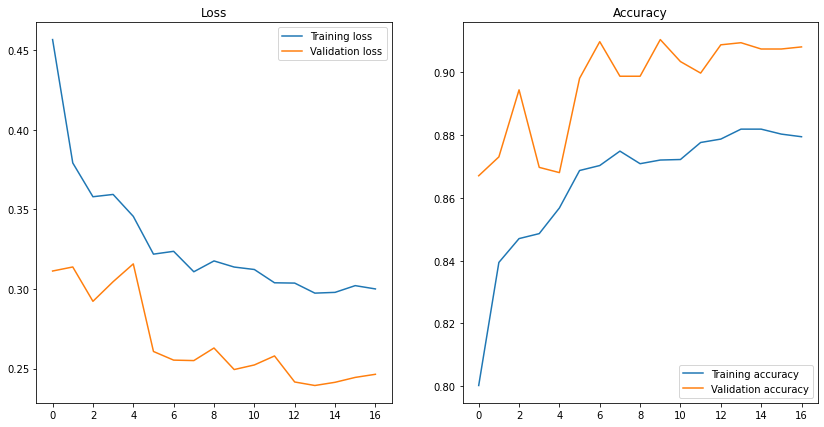

In [ ]:
if TRAIN:
    _, ax = plt.subplots(1, 2, figsize=(14, 7))

    sns.lineplot(x=results.epoch, y=results.history["loss"], ax=ax[0], label="Training loss")
    sns.lineplot(x=results.epoch, y=results.history["val_loss"], ax=ax[0], label="Validation loss")
    ax[0].set_title("Loss")

    sns.lineplot(x=results.epoch, y=results.history["accuracy"], ax=ax[1], label="Training accuracy")
    sns.lineplot(x=results.epoch, y=results.history["val_accuracy"], ax=ax[1], label="Validation accuracy")
    _ = ax[1].set_title("Accuracy")

## Evaluate
Get predictions for validation set and print classification report

In [ ]:
model.load_weights(OUTPUT_FOLDER_CUR / "chest_xray_binary_best.h5")

In [ ]:
[val_loss, val_accuracy, val_prec, val_rec, val_pr_auc] = model.evaluate(valid_dataset, callbacks=[tfa.callbacks.TQDMProgressBar()], verbose=1)

125/125 [==============================] - 350s 3s/step - loss: 0.2427 - accuracy: 0.9073 - prec: 0.9157 - rec: 0.9558 - pr_auc: 0.9831



In [ ]:
valid_pred_probabilities = model.predict(
    valid_dataset,
    callbacks=[tfa.callbacks.TQDMProgressBar()]
)

In [ ]:
valid_predictions = (valid_pred_probabilities > THRESHOLD).reshape(-1).astype(np.int32)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(valid_dataset.classes, valid_predictions, target_names=list(train_dataset.class_indices.keys()),))

              precision    recall  f1-score   support

    abnormal       0.72      0.94      0.82       898
      normal       0.97      0.85      0.90      2102

    accuracy                           0.87      3000
   macro avg       0.85      0.89      0.86      3000
weighted avg       0.90      0.87      0.88      3000



Text(0.5, 1.0, 'Precision-Recall Curve')

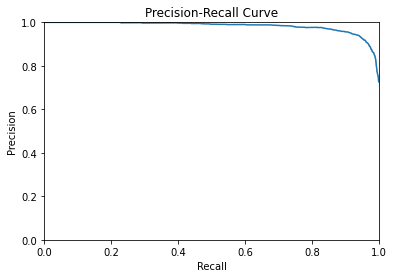

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(valid_dataset.classes, valid_pred_probabilities)

ax = sns.lineplot(x=recall, y=precision)
ax.set(xlabel="Recall", ylabel="Precision")
ax.axis([0, 1, 0, 1])
ax.set_title("Precision-Recall Curve")

## Predict

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class_id_to_name = {v: k for k, v in train_dataset.class_indices.items()}
images = list((INPUT_FOLDER_PNG / "test").iterdir())
results = pd.DataFrame(columns=["image_id", "class_name", "confidence"])

for image_file in tqdm(images, total=len(images)):
    image = load_img(image_file, target_size=IMAGE_SIZE)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    pred_prob = model.predict(image)
    pred = int((pred_prob > THRESHOLD).squeeze())
    pred_prob = float(pred_prob.squeeze())

    results = results.append({"image_id": image_file.stem, "class_name": class_id_to_name[pred], "confidence": pred_prob}, ignore_index=True)

results.to_csv(OUTPUT_FOLDER_CUR / "prediction.csv", index=False)
results.sample(5)

,image_id,class_name,confidence
2311,4a6d4be950d20bd987baaabf6a986ab0,normal,0.956445
258,0d8b5533f40cf4b0c3f2d86b1d61d6bc,normal,0.986976
2167,bac58dc3a82b5a3d1f1affc2e9a5d6cf,abnormal,0.294995
2082,42480dff233be45d4fdca62069ea267f,abnormal,0.687130
1841,e111eca0927c8bf0f0201915d6f37c6d,abnormal,0.147686


## Store output to Kaggle

In [ ]:
version_message = f"{version_notes}; image size: {IMAGE_SIZE}; threshold: {THRESHOLD}"
!echo "{version_message}"

dump_dataset_metadata("witalia", "vbdbinary", OUTPUT_FOLDER_CUR)

# !kaggle datasets create -p {OUTPUT_FOLDER_CUR} -r zip
!kaggle datasets version -m "{version_message}" -p {OUTPUT_FOLDER_CUR} -r zip

EfficientNetB3, include probabilities (for later double thresholding); image size: (640, 640); threshold: 0.8
Starting upload for file chest_xray_binary_best.h5
100% 59.8M/59.8M [00:05<00:00, 11.3MB/s]
Upload successful: chest_xray_binary_best.h5 (60MB)
Starting upload for file prediction.csv
100% 175k/175k [00:04<00:00, 39.6kB/s]
Upload successful: prediction.csv (175KB)
Starting upload for file chest_xray_binary.h5
100% 59.8M/59.8M [00:08<00:00, 7.65MB/s]
Upload successful: chest_xray_binary.h5 (60MB)
Dataset version is being created. Please check progress at https://www.kaggle.com/witalia/vbdbinary
